# MAC0460/5832 - Lista 1: Aprendizado de W-Operadores

Luis Gustavo Moneda dos Santos - 5917641

#### Considerações

- Mudei a função `draw_img` do `utils.py`, substituindo a primeira linha por `H, W = img.shape`;

#### Referências

- [Training Image Operators from Samples - Research at IME-USP](http://www.vision.ime.usp.br/projects/trios/basic_formulation/)
- [Morfologia Matemática: teoria, sistemas e aplicações](http://www.vision.ime.usp.br/~jb/lectures/overview/titular.pdf)

In [5]:
%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime

ERROR:root:Line magic function `%install_ext` not found.


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pandas as pd

from mac0460_5832.utils import *

time: 274 ms


# Questões

## Questão 1

Encontre, utilizando a técnica de aprendizado de w-operadores vista em sala, o operador 1x3 (1 linha, 3 colunas) capaz de transformar a imagem src1 em dest1 (veja as variáveis abaixo) mostrando a tabela de padrões encontrada. Teste seu operador na imagem src1 e verifique que ele funciona como esperado. Teste seu operador nas imagens images/q1/1_test1.png e images/q1/1_test2.png desenhando as imagens obtidas (sugestão: use a função draw_img do arquivo mac0460_5832/utils.py).

## Resposta Q1

Nós queremos aprender um w-operador, ou seja, um operador em região, que seja capaz de levar a imagens de entrada $I$ para as imagens de saída $O$, de tal forma que: $f(I_i) = O_i$. No nosso caso o arquivo `1_src.png` é o $I_1$, enquanto o `1_dest.png` seria o $O_1$.

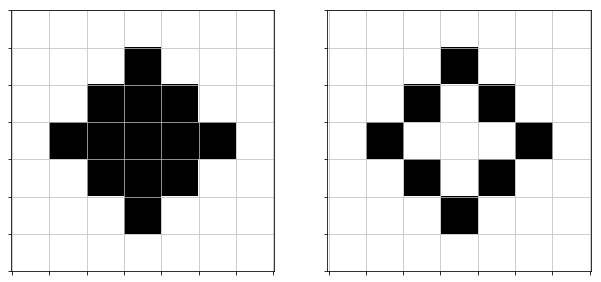

time: 283 ms


In [7]:
src1 = read_img('images/q1/1_src.png')
dest1 = read_img('images/q1/1_dest.png')

draw_img_pair(src1, dest1)

In [8]:
operator = np.ones((1, 3))

time: 1.04 ms


Visualizando:

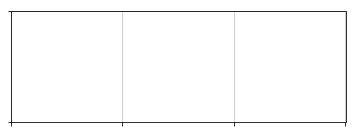

time: 101 ms


In [9]:
draw_img(operator)

In [169]:
import pdb
from sklearn.metrics import precision_score, recall_score, f1_score
from time import time
from toolz import curry
from joblib import Parallel, delayed
from multiprocessing import cpu_count, Pool
from tqdm import tnrange, tqdm_notebook
import matplotlib.pyplot as plt

def find_center(a):
    """
    a: array
    """
    r = int(a.shape[0] / 2)
    c = int(a.shape[1] / 2)
    
    return (r, c)

def extract_window(image, W, stride=0):
    ### Zero Padding
    W_center = find_center(W)
    vertical_shift = (W.shape[0] - 1) - W_center[0]
    horizontal_shift = (W.shape[1] - 1) - W_center[1]
    pad_width = max([vertical_shift, horizontal_shift])
    im = np.pad(image, pad_width, mode="constant", constant_values=0)
    im = im * 1
        
    extracted = []
    for i in range(int(image.shape[0] / (stride + 1))):
        i += pad_width 
        i += i*stride
        for j in range(int(image.shape[1] / (stride + 1))):
            j += pad_width
            j += j*stride
            #pdb.set_trace()
            extracted.append((W * im[i-vertical_shift:i+vertical_shift+1, j-horizontal_shift:j+horizontal_shift+1]).astype(int))
                
    return extracted

def accuracy_score(y_true, y_pred):
    pairs = list(zip(y_true, y_pred))
    accuracies = [np.sum(pair[0] == pair[1]) / len(pair[0].flatten()) for pair in pairs]
    return np.mean(np.array(accuracies))

def mse_score(y_true, y_pred):
    pairs = list(zip(y_true, y_pred))
    mses = [np.mean(np.power(pair[0] - pair[1], 2)) for pair in pairs]
    return np.mean(np.array(mses))

    return 0

def first_array(x):
    return list(x[0])
    
def train_w(I, O, W_shape, operator=[], stride=0, verbose=True, multiproc=False):
    """
    I: list of input images
    O: list of output images
    W_shape: window shape
    """
    if len(operator) == 0:
        W = np.ones(W_shape)
    else:
        W = operator
        
    ###
    if multiproc:
        pass
    else:
        list_of_patterns = [extract_window(i.astype(int), W, stride) for i in I]
        X_train = [pattern for patterns in list_of_patterns for pattern in patterns]
        
        list_of_labels = [extract_window(o.astype(int), np.ones((1,1))) for o in O]
        y_train = [label for labels in list_of_labels for label in labels]
        
    ### Multiply X_train by W considering the 1s and 0s
#     if len(operator) == 0:
#         X_train = [pattern * operator for pattern in X_train]
        
    start = time()
    ### Fit
    df = pd.DataFrame()
    df["pattern"] = X_train
    df["array"] = X_train
    df["y"] = y_train
    df["y"] = df["y"].apply(lambda x : x[0][0])
    df["pattern"] = df["pattern"].apply(lambda x : str(x.astype(int)))    
    threshold = np.mean(y_train)
    f = df.groupby("pattern", as_index=False).agg({"y": "mean", "array": lambda x : list(x)})
    f["array"] = f["array"].apply(lambda x : x[0])
    
    
    f["y"] = (f["y"] > threshold) * 1 
    
    
    if verbose:
        print('Fitting: {0}m{1}s'.format(int((time()-start)/60), int((time()-start)%60 )))        
    
    start = time()
    ### Predict
    y_pred = [predict(f, im, W) for im in I]   
    if verbose:
        print('Predict: {0}m{1}s'.format(int((time()-start)/60), int((time()-start)%60 )))        
    
    ### Friendly format to calc the metrics
    y_true = [y[0][0] for y in y_train]
    y_hat = [x for p in [y for y_p in y_pred for y in y_p] for x in p]

    start = time()
    ### metrics to log
    accuracy = accuracy_score(O, y_pred)    
    precision = precision_score(y_true, y_hat)
    recall = recall_score(y_true, y_hat)
    mse = mse_score(O, y_pred)    
    f1 = f1_score(y_true, y_hat)
    if verbose:
        print('Metrics: {0}m{1}s'.format(int((time()-start)/60), int((time()-start)%60 )))        
    
    logs = {}
    logs["accuracy"] = accuracy
    logs["mse"] = mse    
    logs["precision"] = precision
    logs["recall"] = recall
    logs["f1"] = f1
    
    if verbose:
        print("Training metrics: ")
        print("Threshold: {:.2f}".format(threshold))
        print("Accuracy: {:0.2f}".format(accuracy))    
        print("Precision: {:0.2f}".format(precision))
        print("Recall: {:0.2f}".format(recall))
        print("MSE: {:0.2f}".format(mse))
        print("F1: {:0.2f}".format(f1))
    
    return X_train, y_train, f, logs

def learning_curve(I, O, W_shape, T, operator=[], stride=0, verbose=False, multiproc=False):
    
    train_errors = []
    test_errors = []
    for i in tqdm_notebook(range(1, len(I))):
        train_images = I[:i]
        train_output = O[:i]
        X_train, y_train, f, logs = train_w(train_images, train_output, w.shape, operator, verbose=verbose)
        
        train_errors.append(1 - logs["accuracy"])

        ### Test error
        y_pred = [predict(f, im, operator) for im in T]   
        y_hat = [x for p in [y for y_p in y_pred for y in y_p] for x in p]
        
        accuracy = accuracy_score(O, y_pred)
        test_errors.append(1 - accuracy)
        
    plt.plot(train_errors, label="Ein")
    plt.plot(test_errors, label="Eout")
    plt.title("Learning Curve")
    plt.xlabel("Number of training images")
    plt.ylabel("Percentage of incorrect predicted pixels")
    plt.legend()
    plt.show()
    
def retrieve_prediction(f, pattern):
    try:
        prediction = f[f["pattern"] == str(pattern)]["y"].values[0]
    except:
        prediction = 0
        
    return prediction
                        
def predict(f, image, W):
    """
    
    """
    extracted_feats = extract_window(image, W)    

    ### Multiproc
    partitions = cpu_count()
    result = Parallel(n_jobs= partitions, max_nbytes=None)(delayed(retrieve_prediction)(f, pattern) for pattern in extracted_feats)

    ### Single thread
    #result = [retrieve_prediction(f, feat) for feat in extracted_feats]    
    
    output = np.array(result).reshape(image.shape)
    
    return output

def multiresolution_predict(functions, image, windows):
    output = np.zeros(image.shape)
    result = []
    extracted_feats = [extract_window(image, W) for W in windows]
    
    for pixel in range(np.size(image)):
        prediction = None
        for i, function in enumerate(functions):
            try:
                prediction = function[function["pattern"] == str(extracted_feats[i][pixel])]["y"].values[0]                
                break
            except:
                pass
        if prediction == None:
            prediction = 0
        result.append(prediction)
                                      
    return np.array(result).reshape(image.shape)

def print_patterns(patterns):
    
    for pattern in patterns:
        draw_img(pattern)

time: 1.44 s


Fitting: 0m0s
Predict: 0m0s
Metrics: 0m0s
Training metrics: 
Threshold: 0.16
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
MSE: 0.00
F1: 1.00


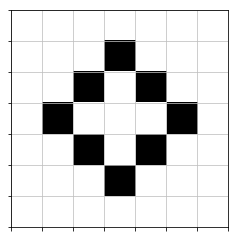

time: 713 ms


In [170]:
w = np.ones((1, 3))
X_train, y_train, f, _ = train_w([src1, src1], [dest1, dest1], w.shape, w)

draw_img(predict(f, src1, w))

Padrões encontrados:

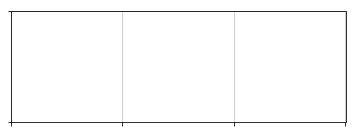

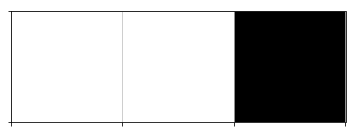

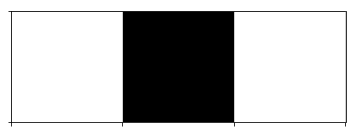

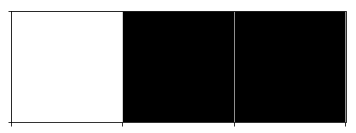

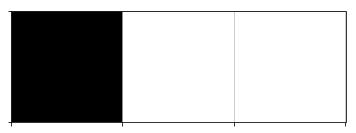

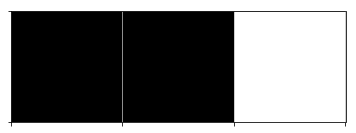

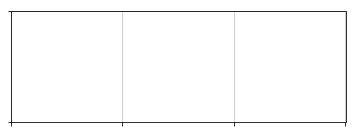

time: 659 ms


In [171]:
for pattern in f["array"]:
    draw_img(pattern)

In [172]:
test1_1 = read_img('images/q1/1_test1.png')
test1_2 = read_img('images/q1/1_test2.png')

time: 4.29 ms


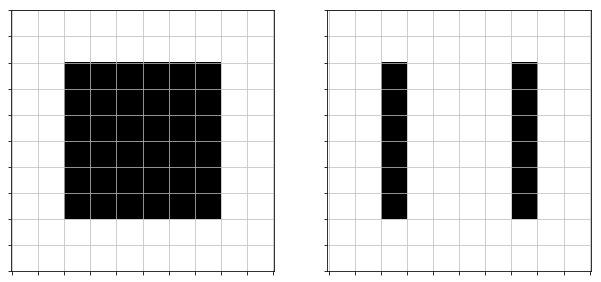

time: 463 ms


In [173]:
output = predict(f, test1_1, w)
draw_img_pair(test1_1, output)

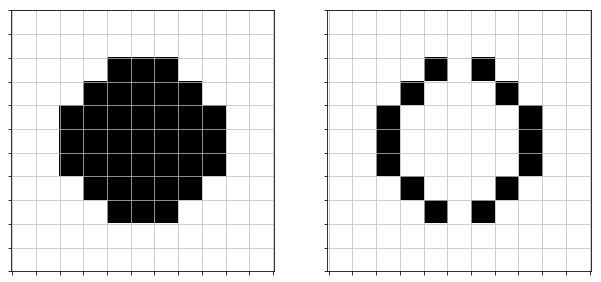

time: 463 ms


In [174]:
output = predict(f, test1_2, w)
draw_img_pair(test1_2, output)

## Questão 2

Aprenda o operador 3x3 para detecção de bordas. Treine seu operador nas imagens da pastas images/q2/ usando os pares (q2_src\*.png, q2_dest\*.png). Teste seu operador nas imagens images/q2/q2_test.png e images/q2/q2_test2.png. Algumas das imagens de treino são desenhadas abaixo.

In [175]:
n_train = 5
train_images = [read_img("images/q2/q2_src" + str(i) + ".png") for i in range(1, n_train+1)]
train_output = [read_img("images/q2/q2_dest" + str(i) + ".png") for i in range(1, n_train+1)]

time: 10.4 ms


In [176]:
w = np.ones((3, 3))
X_train, y_train, f, _ = train_w(train_images, train_output, w.shape)

Fitting: 0m3s
Predict: 0m9s
Metrics: 0m0s
Training metrics: 
Threshold: 0.03
Accuracy: 1.00
Precision: 0.95
Recall: 1.00
MSE: 0.00
F1: 0.97
time: 12.9 s


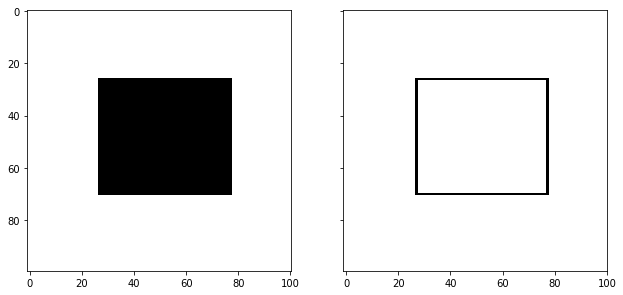

time: 2.14 s


In [177]:
draw_img_pair(train_images[0], predict(f, train_images[0], w))

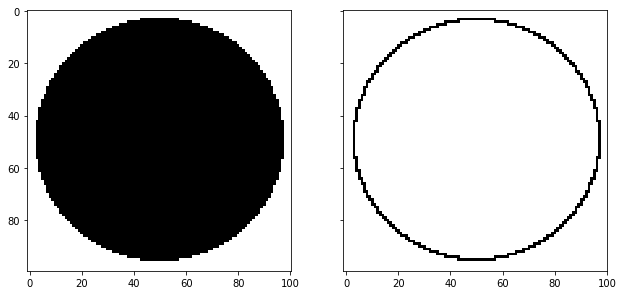

time: 2.13 s


In [178]:
output = predict(f, train_images[1], w)
draw_img_pair(train_images[1], output)

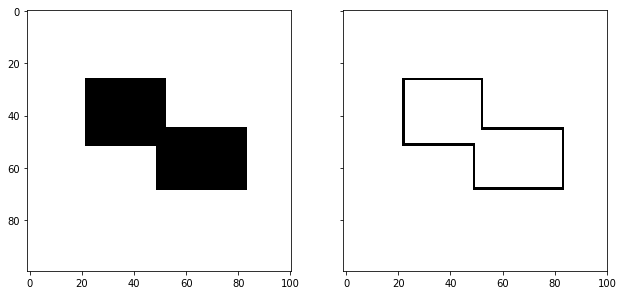

time: 2.19 s


In [179]:
output = predict(f, train_images[2], w)
draw_img_pair(train_images[2], output)

**Test images**

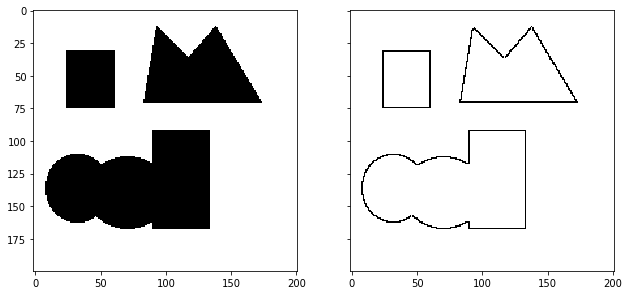

time: 7.09 s


In [180]:
test2_1 = read_img('images/q2/q2_test.png')
test2_2 = read_img('images/q2/q2_test2.png')

output = predict(f, test2_1, w)
draw_img_pair(test2_1, output)

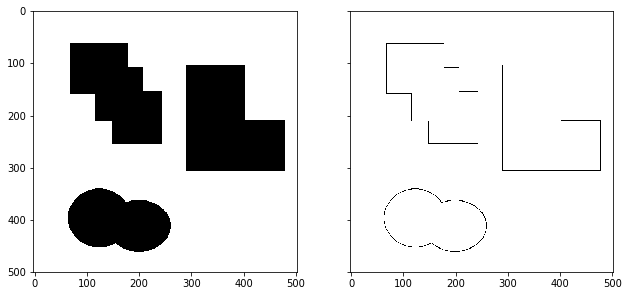

time: 47.7 s


In [181]:
output = predict(f, test2_2, w)
draw_img_pair(test2_2, output)

3 min

## Questão 3

Use o algoritmo de aprendizado para obter um operador capaz de eliminar ruído. Use no treinamento as imagens images/q3/q3_src\*.png sempre com o mesmo target images/q3/q3_dest.png. Teste a janela com 5 elementos (cruz). Teste seu operador nas imagens images/q3/q3_test1.png e images/q3/q3_test2.png. Calcule e plote os erros $E_{in}$ e $E_{out}$ obtidos durante o treinamento.

In [182]:
n_train = 10
train_images = [read_img("images/q3/q3_src" + str(i) + ".png") for i in range(1, n_train+1)]
train_output = [read_img("images/q3/q3_dest.png") for i in range(1, n_train+1)]

time: 9.86 ms


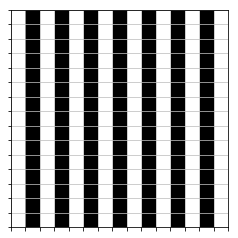

time: 144 ms


In [183]:
draw_img(train_output[0])

In [205]:
w = se_cross()
w

# w = np.ones((3, 3))
# w

array([[0, 1, 0],
       [1, 1, 1],
       [0, 1, 0]])

time: 3.95 ms


Treinando

In [206]:
X_train, y_train, f, _ = train_w(train_images, train_output, w.shape, w)

Fitting: 0m0s
Predict: 0m1s
Metrics: 0m0s
Training metrics: 
Threshold: 0.47
Accuracy: 0.99
Precision: 0.98
Recall: 0.99
MSE: 0.01
F1: 0.99
time: 2.16 s


In [207]:
# for pattern in f["array"]:
#     draw_img(pattern)

time: 1.11 ms


Aplicando nas imagens de treino:

Error 0.00


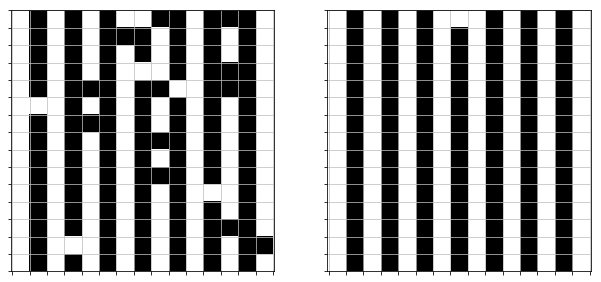

time: 509 ms


In [208]:
output = predict(f, train_images[0], w)
print("Error {:.2f}".format(1 - accuracy_score(train_output[0], output)))
draw_img_pair(train_images[0], output)

Error 0.00


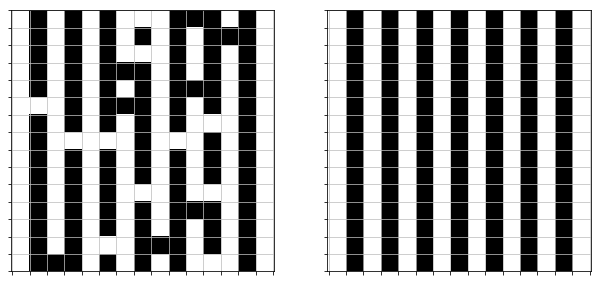

time: 504 ms


In [209]:
output = predict(f, train_images[1], w)
print("Error {:.2f}".format(1 - accuracy_score(train_output[0], output)))
draw_img_pair(train_images[1], output)

Prevendo as imagens de teste:

Error 0.05


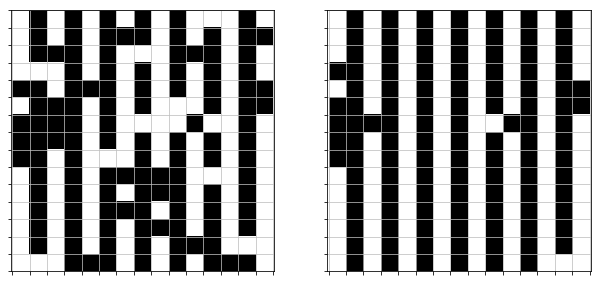

Error 0.05


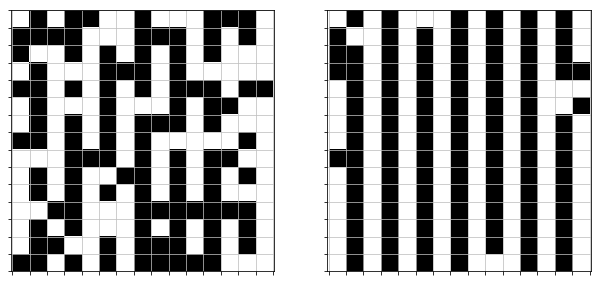

time: 1.02 s


In [210]:
n_test = 2
test_images = [read_img("images/q3/q3_test" + str(i) + ".png") for i in range(1, n_test+1)]

for test_image in test_images:
    output = predict(f, test_image, w)
    print("Error {:.2f}".format(1 - accuracy_score(train_output[0], output)))
    draw_img_pair(test_image, output)

Learning curve:

Widget Javascript not detected.  It may not be installed or enabled properly.


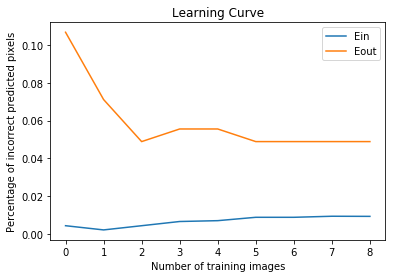

time: 13.8 s


In [211]:
learning_curve(train_images, train_output, w.shape, test_images, w)

## Questão 4

Projete um operador para aprender a extrair a letra 's' de imagens de texto. Para isso utilize os pares de imagens q4_src\*.png q4_dest\*.png da pasta images/q4/train. Teste seu operador nas imagens da pasta images/q4/test. Utilize a composição de janelas pequenas. Avalie o erro do seu operador comparando a saída obtida por ele com a saída esperada (imagens q4_gt\*.png da pasta images/q4/test).

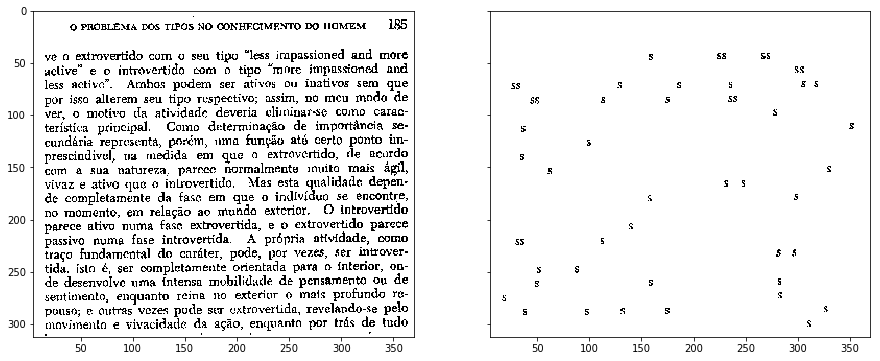

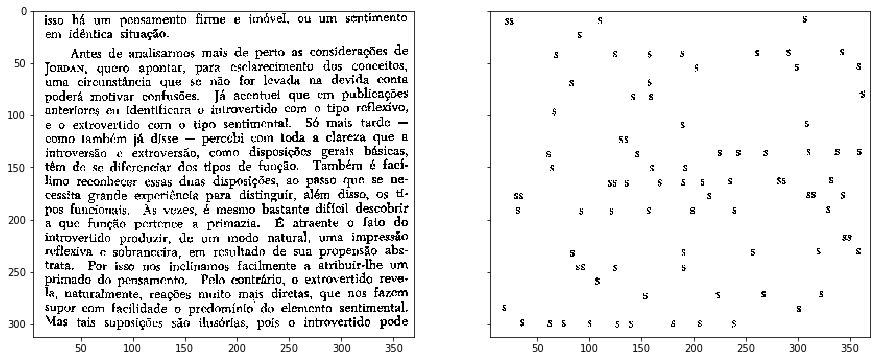

time: 722 ms


In [112]:
dest4_1a = read_img("images/q4/train/q4_dest1a.png")
src4_1a = read_img("images/q4/train/q4_src1a.png")
dest4_1b = read_img("images/q4/train/q4_dest1b.png")
src4_1b = read_img("images/q4/train/q4_src1b.png")
draw_img_pair(src4_1a, dest4_1a, figsz=(15, 6))
draw_img_pair(src4_1b, dest4_1b, figsz=(15, 6))

In [ ]:
#w = se_cross()
w = np.ones((5, 5))
X_train, y_train, f, logs = train_w([src4_1a, src4_1b], [dest4_1a, dest4_1b], w.shape, w)

Feature extraction: 0m0s
Operator conforming: 0m0s
Fitting: 0m26s


Process ForkPoolWorker-258:
Process ForkPoolWorker-264:
Process ForkPoolWorker-261:
Process ForkPoolWorker-263:
Process ForkPoolWorker-257:
Process ForkPoolWorker-259:
Process ForkPoolWorker-262:
Process ForkPoolWorker-260:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/lgmoneda/miniconda2/envs/ml3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/lgmoneda/miniconda2/envs/ml3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/lgmoneda/miniconda2/envs/ml3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/lgmoneda/miniconda2/envs/ml3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    sel

KeyboardInterrupt: 

time: 21min 55s


ERROR:tornado.general:Uncaught exception, closing connection.
Traceback (most recent call last):
  File "/Users/lgmoneda/miniconda2/envs/ml3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/lgmoneda/miniconda2/envs/ml3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/lgmoneda/miniconda2/envs/ml3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/lgmoneda/miniconda2/envs/ml3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/lgmoneda/miniconda2/envs/ml3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 421, in execute_request
    self._abort_queues()
  File "/Users/lgmoneda/miniconda2/envs/ml3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 637, in _

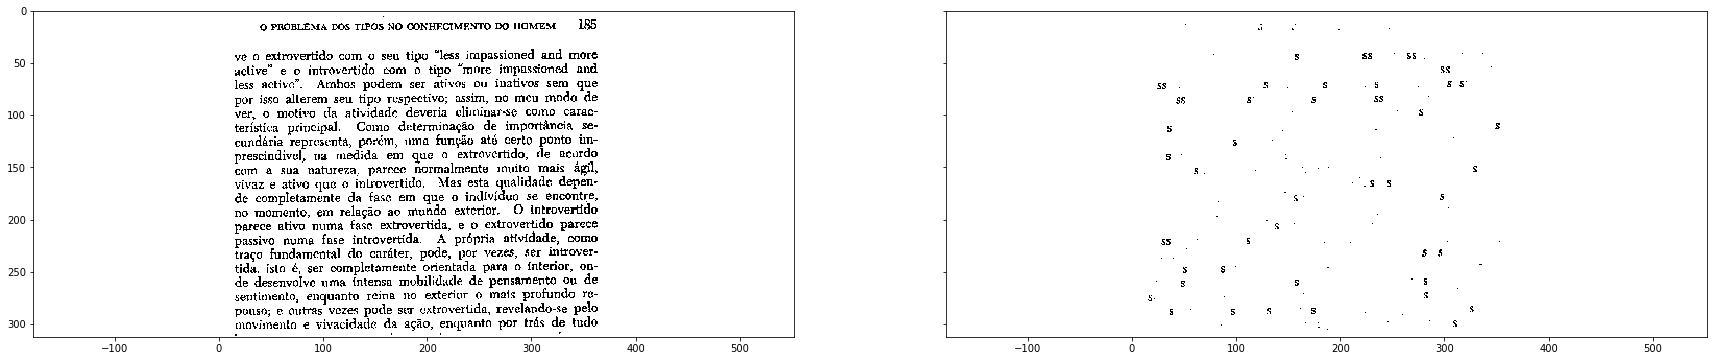

time: 12min 5s


In [35]:
out4_1a = predict(f, src4_1a, w)
draw_img_pair(src4_1a, out4_1a, figsz=(30, 6))

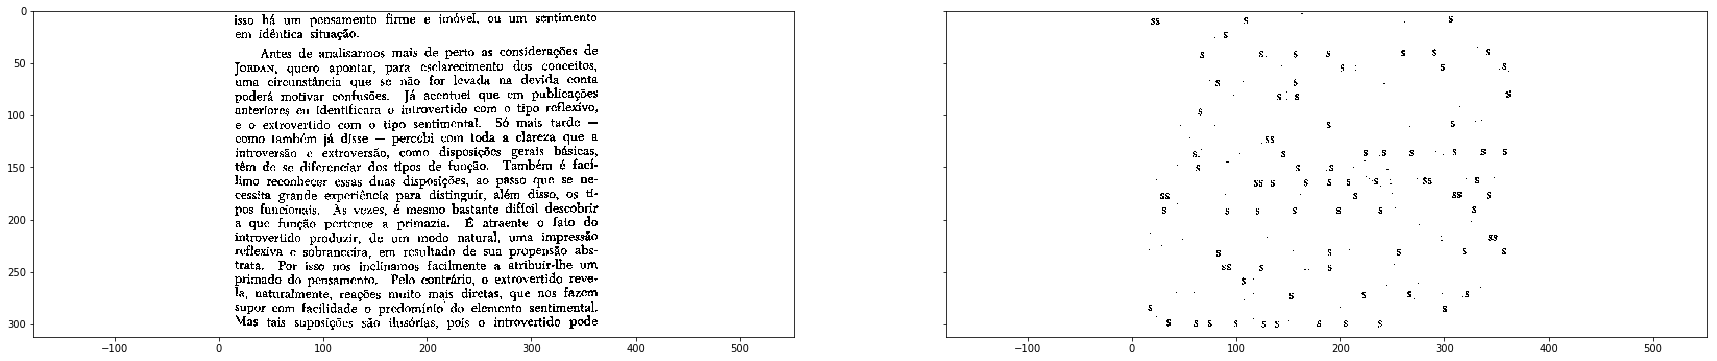

time: 11min 29s


In [36]:
out4_1b = predict(f, src4_1b, w)
draw_img_pair(src4_1b, out4_1b, figsz=(30, 6))

In [37]:
%time
w2 = np.ones((3, 3))
X_train, y_train, g, logs_g = train_w([out4_1a, out4_1b], [dest4_1a, dest4_1b], w2.shape, w2)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs
Training metrics: 
Threshold: 0.01
Accuracy: 1.00
Precision: 0.92
Recall: 1.00
MSE: 0.00
F1: 0.96
time: 2min 52s


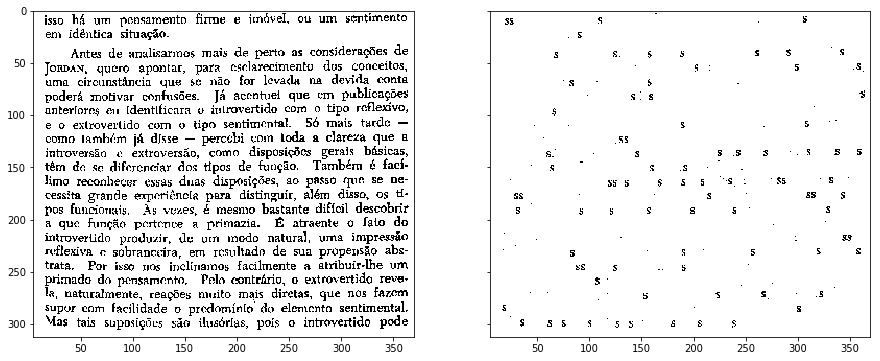

time: 13min 6s


In [38]:
draw_img_pair(src4_1b, predict(g, predict(f, src4_1b, w), w2), figsz=(15, 6))

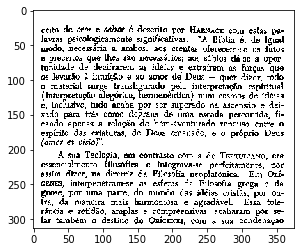

time: 164 ms


In [40]:
test4_1a = read_img("images/q4/test/q4_test10a.png")
draw_img(test4_1a)

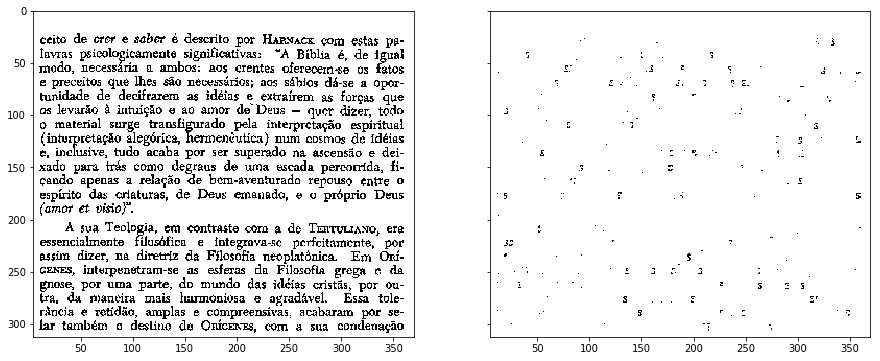

time: 13min 13s


In [41]:
draw_img_pair(test4_1a, predict(g, predict(f, test4_1a, w), w2), figsz=(15, 6))

## Questão 5


Utilizando a técnica de multiresolução, aprenda o operador capaz de remover ruído das imagens da pasta images/q5/. Utilize os pares de imagens (q5_src\*.png, q5_dest.png) para o treinamento e depois teste seu  operador nas imagens q5_test1.png e q5_test2.png.

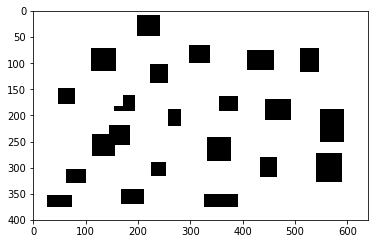

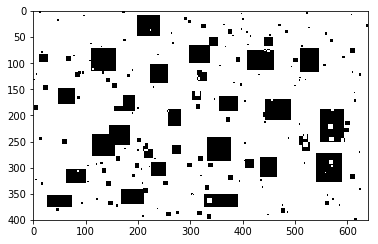

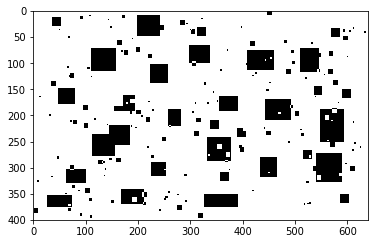

time: 449 ms


In [26]:
dest5 = read_img("images/q5/q5_dest.png")
src5_1 = read_img("images/q5/q5_src1.png")
src5_2 = read_img("images/q5/q5_src2.png")
draw_img(dest5)
draw_img(src5_1)
draw_img(src5_2)

In [42]:
n_train = 10
train_images = [read_img("images/q5/q5_src" + str(i) + ".png") for i in range(1, n_train+1)]
train_output = [read_img("images/q5/q5_dest.png") for i in range(1, n_train+1)]

time: 54.3 ms


Vou treinar 3 W-operadores: 3x3 e 2x2

In [43]:
w_sizes = [8, 5, 3]
windows = [np.ones((w, w)) for w in w_sizes]
functions = []
for window in windows:
    X_train, y_train, f, logs = train_w(train_images, train_output, window.shape, window)
    functions.append(f)

Training metrics: 
Threshold: 0.13
Accuracy: 0.97
Precision: 0.84
Recall: 0.99
MSE: 0.03
F1: 0.91
Training metrics: 
Threshold: 0.13
Accuracy: 0.97
Precision: 0.83
Recall: 0.99
MSE: 0.03
F1: 0.90
time: 1h 27min 35s


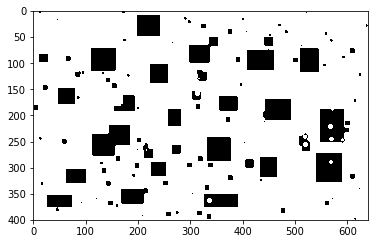

time: 4min 36s


In [44]:
output = multiresolution_predict(functions, src5_1, windows)
draw_img(output)

In [45]:
test5_1 = read_img("images/q5/q5_test1.png")
output = multiresolution_predict(functions, test5_1, windows)

time: 5min 6s


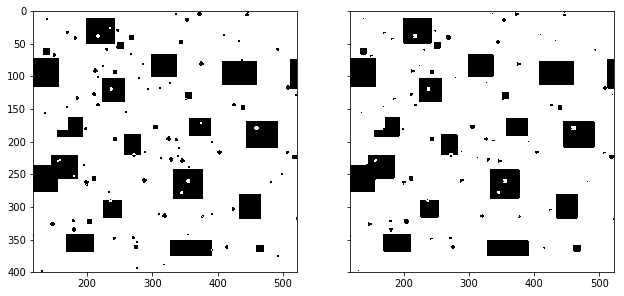

time: 380 ms


In [46]:
draw_img_pair(test5_1, output)

## Questão 6


Utilize a técnica de envelope, como visto em sala, para remover ruído de imagens. Use o mesmo dataset da questão anterior e as funções de morfologia disponíveis em mac0460_5832/utils.py para definir as funções $\alpha$ e $\beta$. Um exemplo de erosão em uma das imagens de treino é mostrado abaixo. Comente sobre a escolha das funções $\alpha$ e $\beta$.

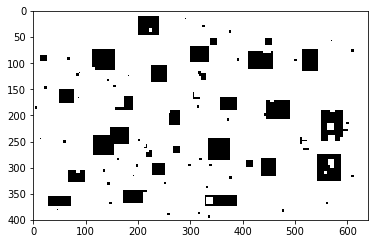

In [31]:
src6_1 = read_img("images/q5/q5_src1.png")
draw_img(erosion(src6_1, se_box(2)))

## Questão 7

A função gen_rand_imgs abaixo retorna um par de imagens. A primeira contém alguns pontos gerados aleatoriamente. A segunda é a dilatação da primeira por um elemento estruturante em forma de cruz. Aprenda o operador capaz de realizar essa transformação, gerando os pares de src e dest. Crie os dados de treinamento baseado na equação vista em sala ($m(\epsilon, \delta, H) = \frac{1}{\epsilon}ln\frac{|H|}{\delta}$). Compare o resultado obtido pelo seu classificador (gere mais pares para teste e ter uma estimativa de $E_{out}$) para $\epsilon = [0.2, 0.1]$ e $\delta = [0.3, 0.2]$.

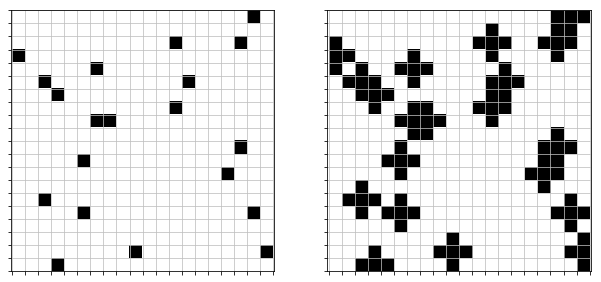

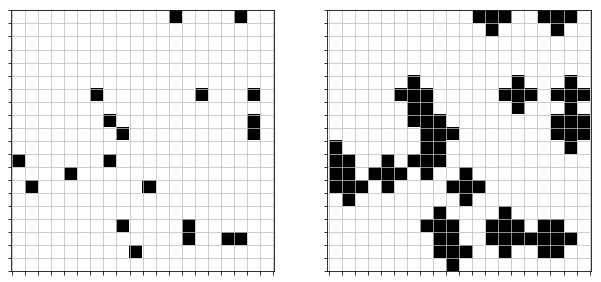

In [32]:
def gen_rand_imgs():
    noise = np.zeros((20, 20)).astype(bool)
    num_pixels = 20
    x = np.random.randint(0, 20, num_pixels)
    y = np.random.randint(0, 20, num_pixels)

    for i in range(num_pixels):
        noise[x[i], y[i]] = 1

    return noise, dilation(noise, se_cross(1))

src5_1, dest5_1 = gen_rand_imgs()
src5_2, dest5_2 = gen_rand_imgs()
draw_img_pair(src5_1, dest5_1)
draw_img_pair(src5_2, dest5_2)